# App permissions

Data format transformation to aid our design team for visualization. The output of the Google Play 'scraper' is such:

![](perms-scraperoutput.png)

    app_1, perm_1, perm_2, perm_3, perm_4, ...
    app_2, perm_2, perm_3, perm_4, perm_6, perm_7, ...
    .
    .
    .
    
But a nice format would be dummy variable style with aligned, equal length vectors.

![](perms-matrix.png)

The designers made this sketch, which is serving as a material lighthouse to work towards.

![](visualization-sketch.png)
    
I talked to our 🇮🇹 designers after Tuesday working day, and they said they would prefer for their dataviz sketch

In the below photo, $n_n$ indicates nesting to be ignored.

![](perms-permsperapps.png)

In [163]:
import pandas as pd
import numpy as np
import scipy, scipy.spatial.distance, scipy.cluster
import matplotlib.pyplot as plt
import csv
import pprint

%matplotlib inline

First of all, read output file of the scraper tool.

In [2]:
#filepath = 'dating_apps_permissions_test.csv - dating_apps_permissions_test.csv'
#filepath = 'dating_apps_bigger_crawl.csv'
filepath = 'dating_apps_20170705_1400.csv'

scraped = {}

with open(filepath) as fd:
    for line in fd.readlines():
        values = [v for v in line.split('\t') if v.strip() != '']
        scraped[values[0]] = values[1:]

# pprint.pprint(perms)

Some manual interventions were done after the scraping. It's described more exhaustively in the protocol I guess, but we dropped *Once*, and added *The League*.

In [3]:
del scraped["com.once.android"]

In [4]:
scraped["com.league.theleague"] = ["precise location (GPS and network-based)",
                                   "read the contents of your USB storage",
                                   "modify or delete the contents of your USB storage",
                                   "receive data from Internet",
                                   "view network connections",
                                   "full network access",
                                   "run at startup",
                                   "control vibration",
                                   "prevent device from sleeping",
                                   "approximate location (network-based)",
                                   "read sensitive log data",
                                   "take pictures and videos"]

In [5]:
rationale = pd.read_csv("Dating Apps - Sheet1.csv", index_col="Google Play Store ID")
print(rationale.shape)
rationale.sample(3)

(41, 6)


,App name,Category,Why include it?,Login,Connected social media,App-store link
Google Play Store ID,,,,,,
com.adam4adam.radar2.ui,Adam4Adam,Popular Gay dating,NaN,NaN,NaN,NaN
com.ipart.android,iPair,Popular Local apps,most popular in Taiwan (BBC),NaN,NaN,NaN
(only Appstore),The League,Elite,elite,LinkedIn & Facebook,NaN,https://itunes.apple.com/us/app/the-league-mee...


In [6]:
rationale[['App name', 'Category']].to_csv("rationale.csv")

Then infer from given values what are the permissions on Google Play, in no particular order. A better way might be to have an exhaustive list.

In [7]:
androidperms = []

for app in scraped.values():
    for perm in app:
        perm = perm.strip().lower()
        if perm not in androidperms:
            androidperms.append(perm)

androidperms

['approximate location (network-based)',
 'precise location (gps and network-based)',
 'read phone status and identity',
 'read the contents of your usb storage',
 'modify or delete the contents of your usb storage',
 'take pictures and videos',
 'receive data from internet',
 'view network connections',
 'full network access',
 'run at startup',
 'control vibration',
 'prevent device from sleeping',
 'read google service configuration',
 'find accounts on the device',
 'view wi-fi connections',
 'draw over other apps',
 'use accounts on the device',
 'install shortcuts',
 'uninstall shortcuts',
 'retrieve running apps',
 'read your contacts',
 'read your text messages (sms or mms)',
 'receive text messages (sms)',
 'send sms messages',
 'record audio',
 'read home settings and shortcuts',
 'pair with bluetooth devices',
 'access bluetooth settings',
 'change network connectivity',
 'allow wi-fi multicast reception',
 'connect and disconnect from wi-fi',
 'change your audio settings',


There are so many Android permissions that were inferred from the data.

In [8]:
len(androidperms)

62

These should be thought about which are inputs, which are outputs, and which something else (like both).

Ok, let's build a `pandas.DataFrame` with apps as rows, and dummy encoded permissions as columns.

In [9]:
perms = pd.DataFrame(columns=androidperms)

for app in scraped:
    s = pd.Series(index=androidperms, name=app, dtype=bool)
    for aperm in androidperms:
        s[aperm] = aperm in scraped[app]
    perms = perms.append(s)

perms.shape

(38, 62)

In [224]:
perms

,approximate location (network-based),precise location (gps and network-based),read phone status and identity,read the contents of your usb storage,modify or delete the contents of your usb storage,take pictures and videos,receive data from internet,view network connections,full network access,run at startup,...,capture audio output,manage document storage,read sync statistics,download files without notification,add or modify calendar events and send email to guests without owners' knowledge,read call log,write call log,read your web bookmarks and history,send download notifications.,write web bookmarks and history
com.adam4adam.radar2.ui,True,False,True,False,False,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
com.appluvfree,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
com.appspot.scruffapp,True,False,True,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
com.ashleymadison.mobile,False,False,False,False,False,True,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
com.badoo.mobile,True,False,True,False,False,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
com.beetalk,True,False,True,False,False,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
com.blued.international,True,False,True,False,False,True,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
com.boyahoy.android,True,False,True,False,False,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
com.coffeemeetsbagel,True,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
com.ftw_and_co.happn,False,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [11]:
perms.astype(int).to_csv(filepath + "-perms.csv", sep=";")

The above is missing the names of the first columns, so add that manually or solve somehow.

Merge in app name and the categories we gave them.

In [12]:
perms_withotherstuff = rationale[['App name', 'Category']].join(perms, how='right')

Lol the below is weak and needs refactoring but works. Pythonlike, not Pandaslike.

In [13]:
def listperms(df, perms):
    # @param df pandas.DataFrame
    # @param perms list
    rows = []
    for app in df.iterrows():
        for aperm in perms:
            if aperm in app[1]:
                # print(app[0] + "," + aperm)
                #rows.append(app[0] + ";" + aperm)
                rows.append([app[0], aperm])
    return rows

In [14]:
listperms(perms_withotherstuff, androidperms)

[['co.uk.qsoft.gaydar', 'approximate location (network-based)'],
 ['co.uk.qsoft.gaydar', 'precise location (gps and network-based)'],
 ['co.uk.qsoft.gaydar', 'read phone status and identity'],
 ['co.uk.qsoft.gaydar', 'read the contents of your usb storage'],
 ['co.uk.qsoft.gaydar', 'modify or delete the contents of your usb storage'],
 ['co.uk.qsoft.gaydar', 'take pictures and videos'],
 ['co.uk.qsoft.gaydar', 'receive data from internet'],
 ['co.uk.qsoft.gaydar', 'view network connections'],
 ['co.uk.qsoft.gaydar', 'full network access'],
 ['co.uk.qsoft.gaydar', 'run at startup'],
 ['co.uk.qsoft.gaydar', 'control vibration'],
 ['co.uk.qsoft.gaydar', 'prevent device from sleeping'],
 ['co.uk.qsoft.gaydar', 'read google service configuration'],
 ['co.uk.qsoft.gaydar', 'find accounts on the device'],
 ['co.uk.qsoft.gaydar', 'view wi-fi connections'],
 ['co.uk.qsoft.gaydar', 'draw over other apps'],
 ['co.uk.qsoft.gaydar', 'use accounts on the device'],
 ['co.uk.qsoft.gaydar', 'install sh

Would be nice to project from the Pandas DataFrame, but oh well.

In [15]:
with open(filepath + "-permsperapp.csv", "w") as fd:
    writer = csv.writer(fd, delimiter = ";")
    for line in listperms(perms_withotherstuff, androidperms):
        writer.writerow(line)
        
!head -3 dating_apps_bigger_crawl.csv-permsperapp.csv

Ok that's cool for interfacing with the designers. Done.

## Comparison of apps

Which ones are popular permissions, which ones they all share, how do they deviate etc.

Now, what about distances between the apps, based on the permissions they ask? A first question is to see see if there is a discrete subset of permissions, which all the apps share. A (discrete!) shared baseline, in a way.

In [16]:
perms.columns[perms[androidperms].all(axis=0)]

Index(['view network connections'], dtype='object')

Ok how many apps require each permission.

In [17]:
perms.count().sort_values(ascending=False)

write web bookmarks and history                                                     38
draw over other apps                                                                38
change network connectivity                                                         38
access bluetooth settings                                                           38
pair with bluetooth devices                                                         38
read home settings and shortcuts                                                    38
record audio                                                                        38
send sms messages                                                                   38
receive text messages (sms)                                                         38
read your text messages (sms or mms)                                                38
read your contacts                                                                  38
retrieve running apps                      

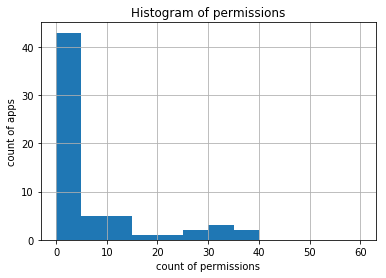

In [18]:
plt.xlabel("count of permissions")
plt.ylabel("count of apps")
plt.title("Histogram of permissions")
perms[androidperms].sum(axis=0).hist(bins=range(0,len(androidperms), 5))

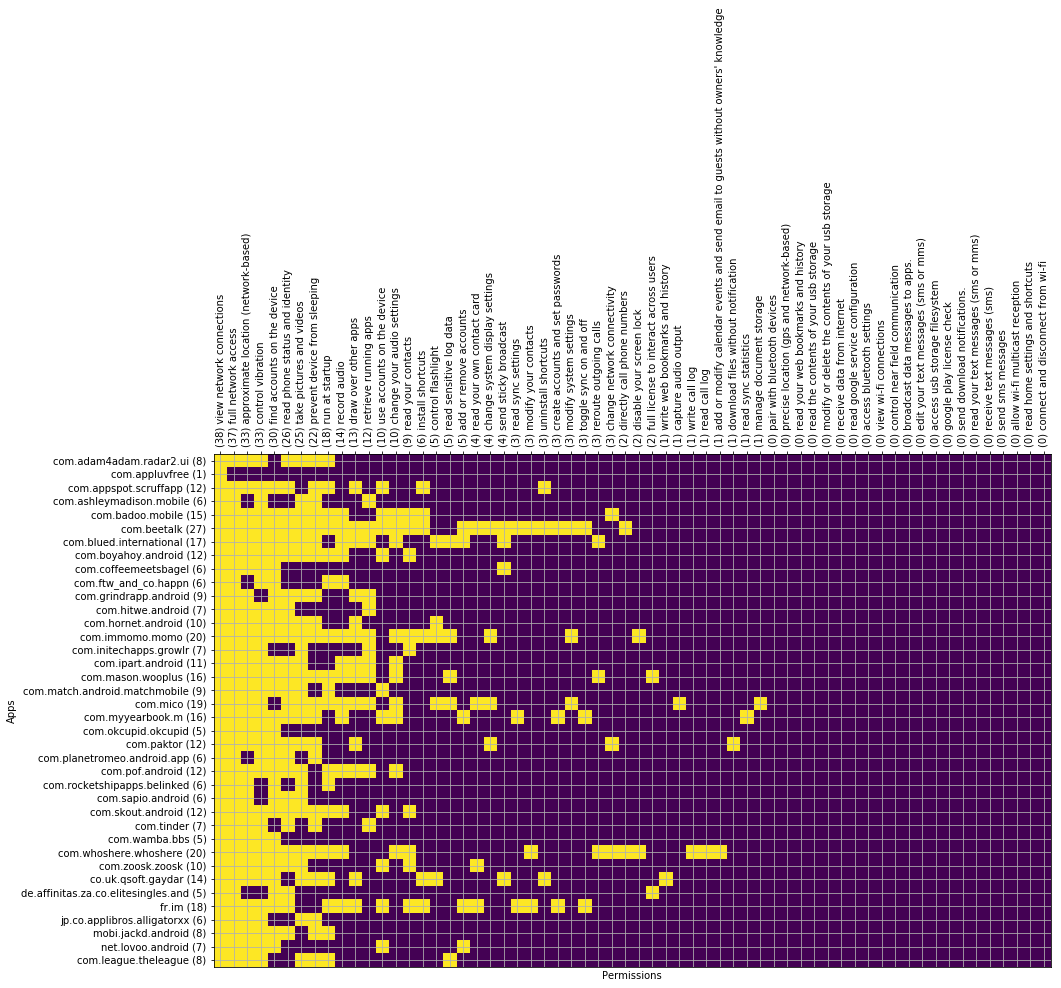

In [153]:
permsbycount = perms.apply(np.sum).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlabel("Permissions")
ax.set_ylabel("Apps")
plt.xticks(range(len(perms.columns)), ["(" + str(perms[perm].sum()) + ") " + perm for perm in perms[permsbycount.index].columns], rotation = 90)
ax.xaxis.tick_top()
plt.yticks(range(len(perms)), [app + " (" + str(perms.loc[app].sum()) + ")" for app in perms.index])
ax.grid()
ax.imshow(perms[permsbycount.index].astype(int))

Let's explore a couple of permissions, which apps require them.

In [154]:
perms[perms['take pictures and videos'] == True].index

Index(['com.adam4adam.radar2.ui', 'com.ashleymadison.mobile',
       'com.badoo.mobile', 'com.beetalk', 'com.blued.international',
       'com.boyahoy.android', 'com.grindrapp.android', 'com.hornet.android',
       'com.immomo.momo', 'com.initechapps.growlr', 'com.ipart.android',
       'com.mason.wooplus', 'com.match.android.matchmobile', 'com.mico',
       'com.myyearbook.m', 'com.paktor', 'com.pof.android',
       'com.rocketshipapps.belinked', 'com.sapio.android', 'com.skout.android',
       'com.whoshere.whoshere', 'com.zoosk.zoosk', 'co.uk.qsoft.gaydar',
       'jp.co.applibros.alligatorxx', 'com.league.theleague'],
      dtype='object')

What distances are there between permissions? How do they cluster?

In [206]:
permdists = pd.DataFrame(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(perms[androidperms].T)), columns=perms.columns, index=perms.columns)
permZ = scipy.cluster.hierarchy.linakage(permdists)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


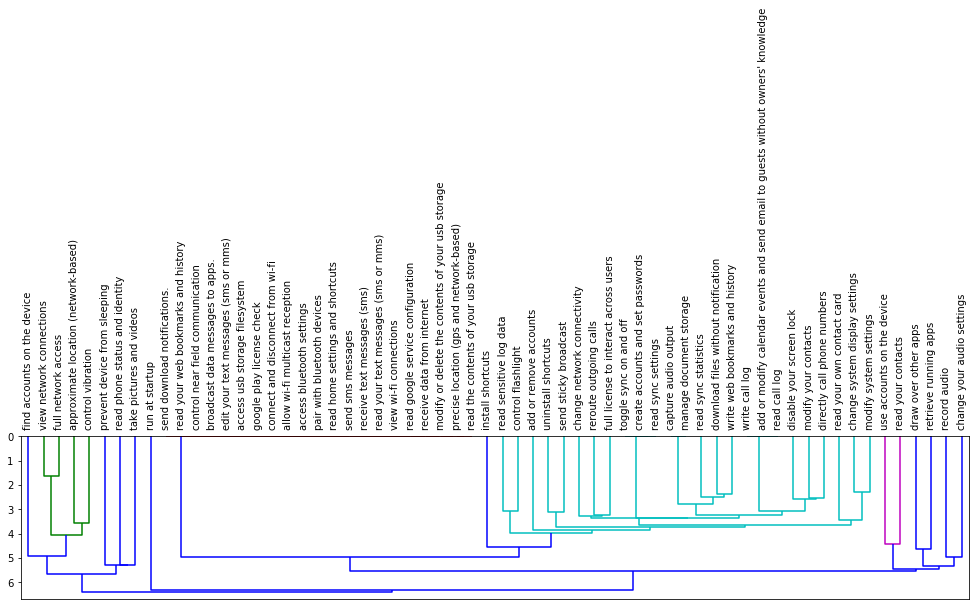

In [223]:
fig, permdentax = plt.subplots(figsize=(17, 3))
dn = scipy.cluster.hierarchy.dendrogram(permZ, labels=perms.columns, orientation='bottom', ax=permdentax, leaf_font_size=10)

What distances are there between the apps.

In [182]:
appdists = pd.DataFrame(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(perms[androidperms].iloc[:, 1:])), columns=perms.index, index=perms.index)

In [183]:
appZ = scipy.cluster.hierarchy.linkage(appdists)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


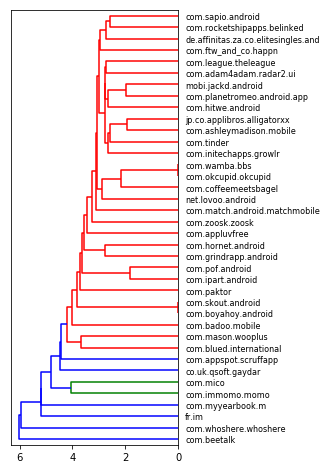

In [184]:
fig, appdentax = plt.subplots(figsize=(3, 8))
dn = scipy.cluster.hierarchy.dendrogram(appZ, labels=perms.index, orientation='left', ax=appdentax)

There are two clusters which seem to be equal, let's eyeball them for validity.

In [236]:
pd.options.display.max_columns = 100
perms.loc[['com.wamba.bbs', 'com.okcupid.okcupid']]

,approximate location (network-based),precise location (gps and network-based),read phone status and identity,read the contents of your usb storage,modify or delete the contents of your usb storage,take pictures and videos,receive data from internet,view network connections,full network access,run at startup,control vibration,prevent device from sleeping,read google service configuration,find accounts on the device,view wi-fi connections,draw over other apps,use accounts on the device,install shortcuts,uninstall shortcuts,retrieve running apps,read your contacts,read your text messages (sms or mms),receive text messages (sms),send sms messages,record audio,read home settings and shortcuts,pair with bluetooth devices,access bluetooth settings,change network connectivity,allow wi-fi multicast reception,connect and disconnect from wi-fi,change your audio settings,google play license check,add or remove accounts,read your own contact card,modify your contacts,directly call phone numbers,create accounts and set passwords,send sticky broadcast,change system display settings,read sync settings,modify system settings,toggle sync on and off,read sensitive log data,reroute outgoing calls,access usb storage filesystem,control flashlight,edit your text messages (sms or mms),broadcast data messages to apps.,control near field communication,disable your screen lock,full license to interact across users,capture audio output,manage document storage,read sync statistics,download files without notification,add or modify calendar events and send email to guests without owners' knowledge,read call log,write call log,read your web bookmarks and history,send download notifications.,write web bookmarks and history
com.wamba.bbs,True,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
com.okcupid.okcupid,True,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [238]:
perms.loc[['com.skout.android', 'com.boyahoy.android']]

,approximate location (network-based),precise location (gps and network-based),read phone status and identity,read the contents of your usb storage,modify or delete the contents of your usb storage,take pictures and videos,receive data from internet,view network connections,full network access,run at startup,control vibration,prevent device from sleeping,read google service configuration,find accounts on the device,view wi-fi connections,draw over other apps,use accounts on the device,install shortcuts,uninstall shortcuts,retrieve running apps,read your contacts,read your text messages (sms or mms),receive text messages (sms),send sms messages,record audio,read home settings and shortcuts,pair with bluetooth devices,access bluetooth settings,change network connectivity,allow wi-fi multicast reception,connect and disconnect from wi-fi,change your audio settings,google play license check,add or remove accounts,read your own contact card,modify your contacts,directly call phone numbers,create accounts and set passwords,send sticky broadcast,change system display settings,read sync settings,modify system settings,toggle sync on and off,read sensitive log data,reroute outgoing calls,access usb storage filesystem,control flashlight,edit your text messages (sms or mms),broadcast data messages to apps.,control near field communication,disable your screen lock,full license to interact across users,capture audio output,manage document storage,read sync statistics,download files without notification,add or modify calendar events and send email to guests without owners' knowledge,read call log,write call log,read your web bookmarks and history,send download notifications.,write web bookmarks and history
com.skout.android,True,False,True,False,False,True,False,True,True,True,True,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
com.boyahoy.android,True,False,True,False,False,True,False,True,True,True,True,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Let's see what is close to OK Cupid.

In [239]:
pprint.pprint(dists['com.okcupid.okcupid'].drop('com.okcupid.okcupid').sort_values())
scipy.argmin(dists['com.okcupid.okcupid'].drop('com.okcupid.okcupid'))

com.wamba.bbs                          0.000000
com.coffeemeetsbagel                   1.000000
com.planetromeo.android.app            1.414214
net.lovoo.android                      1.414214
com.ftw_and_co.happn                   1.414214
com.hitwe.android                      1.414214
com.appluvfree                         1.732051
mobi.jackd.android                     1.732051
jp.co.applibros.alligatorxx            1.732051
de.affinitas.za.co.elitesingles.and    1.732051
com.rocketshipapps.belinked            1.732051
com.sapio.android                      1.732051
com.initechapps.growlr                 2.000000
com.match.android.matchmobile          2.000000
com.ashleymadison.mobile               2.000000
com.tinder                             2.000000
com.zoosk.zoosk                        2.236068
com.adam4adam.radar2.ui                2.236068
com.league.theleague                   2.236068
com.hornet.android                     2.236068
com.ipart.android                      2

'com.wamba.bbs'

Lets eyeball OKCupid with the one that is closest, and the one furthers.

In [158]:
perms.loc[['com.okcupid.okcupid', 'com.wamba.bbs', 'com.beetalk']]

,approximate location (network-based),precise location (gps and network-based),read phone status and identity,read the contents of your usb storage,modify or delete the contents of your usb storage,take pictures and videos,receive data from internet,view network connections,full network access,run at startup,...,capture audio output,manage document storage,read sync statistics,download files without notification,add or modify calendar events and send email to guests without owners' knowledge,read call log,write call log,read your web bookmarks and history,send download notifications.,write web bookmarks and history
com.okcupid.okcupid,True,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
com.wamba.bbs,True,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
com.beetalk,True,False,True,False,False,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False


# To do

* ☑ Validate data reshaping with Emil
* ☑ Write to CSV file
* ☐ Refactor, maybe using `pandas.get_dummies`

# Ideas

Match making for match making apps, based on the data permissions they require. Calculate distance metrics, and suggest top 2. *Get swiping!*

> Feedback from L: why would you date (as a dating app) those like you?
>> Immidiate response: Reversal! Diversity argument, those least similar (business proposal: most permissions with last data set unions)